# Evanescent wave intensity

From the [BornAgain documentation](http://apps.jcns.fz-juelich.de/src/BornAgain/BornAgainManual-1.7.2.pdf) one can see, that for the $q > q_c$ there are two solutions for the Schrödinger equation: reflected wave and transmitted wave. However, for the case $q < q_c$ there is also a real solution, that shows that even when the potential barier is higher than the neutron energy normal to the surface, it can still penetrate to a characteristic depth. This *evanescent wave* travels along the surface with wave vector $k_{||}$ and after a very short time it is ejected out of the bulk in the specular direction \[1\].

Evanescent wave intensity is calculated in BornAgain as

$$I_{ew}(z) = \left|\Psi(z)\right|^2 = \left|R\cdot e^{ik_zz} + T\cdot e^{-ik_zz}\right|^2$$


## Simulate neutron penetration depth for the resonator \[2\]

BornAgain uses the following conventions for the `DepthProbe` geometry description. The surface of the sample will be assigned to $z=0$, while the direction of z-axis will be from the bulk of the sample out to the ambient. Thus, $z<0$ corresponds to the region from the substrate to the surface of the sample, and $z>0$ corresponds to the ambient media.

![Depth Probe Geometry](img/DepthProbeSample.png)

For the sample under consideration, Si block is considered as an ambient medium and D$_2$O as a substrate.

## GUI

1. Start a new project `Welcome view`->`New project`
2. Go to the `Instrument view` and add an **DepthProbe** instrument.
3. Set the instrument parameters as follows.
    ![Depth Probe instrument](img/depth_instr.png)
4. Switch to the `Sample view`. Create a sample made of 6 layers (from bottom to top)
    - D$_2$O substrate, `SLD-based material` with SLD=$6.34\cdot 10^{-6} + i\cdot 1.13\cdot 10^{-13}$
    - TiO$_2$, thickness 3 nm, `SLD-based material` with SLD=$2.63\cdot 10^{-6} + i\cdot 5.4\cdot 10^{-10}$
    - Ti, thickness 10 nm, `SLD-based material` with SLD=$2.8\cdot 10^{-6} + i\cdot 5.75\cdot 10^{-10}$
    - Pt, thickness 32 nm, `SLD-based material` with SLD=$6.36\cdot 10^{-6} + i\cdot 1.9\cdot 10^{-9}$
    - Ti, thickness 13 nm
    - Si ambient layer, `SLD-based material` with SLD=$2.07\cdot 10^{-6} + i\cdot 2.38\cdot 10^{-11}$
5. Switch to `Simulation view`. Click `Run simulation`.

**Exercise:**

Go back to the `Instrument view` and add a Gaussian wavelength distribution with $\frac{\Delta\lambda}{\lambda}=10$%. 

*If got stucked, see the [solution](img/depth_sol01.png)*


## Python API

Since `Export to Python script` does not work for `Depth probe` in BornAgain 1.14.0, see the prepared script below.

## Exercise

1. Modify script below to simulate resonator with 3 Ti/Pt double layers. Hint: use *for* statement, take care about indentations. How number of double layers influences the simulation result?

2. Check for beam divergence parameters for [MARIA](https://mlz-garching.de/maria) instrument. Add Gaussian divergency for incident angle and the wavelength. How does the beam divergency influences the simulation result? What influences more: angular divergence or wavelength divergence?

In [3]:
%matplotlib inline

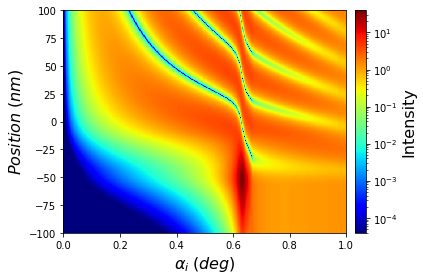

In [4]:
# %load depthprobe_ex.py
import numpy as np
import bornagain as ba
from bornagain import deg, angstrom, nm

# layer thicknesses in angstroms
t_Ti = 130.0 * angstrom
t_Pt = 320.0 * angstrom
t_Ti_top = 100.0 * angstrom
t_TiO2 = 30.0 * angstrom

#  beam data
ai_min = 0.0 * deg  # minimum incident angle
ai_max = 1.0 * deg  # maximum incident angle
n_ai_bins = 500    # number of bins in incident angle axis
beam_sample_ratio = 0.01  # beam-to-sample size ratio
wl = 10 * angstrom  # wavelength in angstroms

# angular beam divergence from https://mlz-garching.de/maria
d_ang = np.degrees(3.0e-03)*deg  # spread width for incident angle
n_points = 50  # number of points to convolve over
n_sig = 3  # number of sigmas to convolve over

# wavelength divergence from https://mlz-garching.de/maria
d_wl = 0.1*wl  # spread width for the wavelength
n_points_wl = 50
n_sig_wl = 2

#  depth position span
z_min = -100 * nm  # 300 nm to the sample and substrate
z_max = 100 * nm   # 100 nm to the ambient layer
n_z_bins = 500


def get_sample():
    """
    Constructs a sample with one resonating Ti/Pt layer
    """

    # define materials
    m_Si = ba.MaterialBySLD("Si", 2.07e-06, 2.38e-11)
    m_Ti = ba.MaterialBySLD("Ti", 2.8e-06, 5.75e-10)
    m_Pt = ba.MaterialBySLD("Pt", 6.36e-06, 1.9e-09)
    m_TiO2 = ba.MaterialBySLD("TiO2", 2.63e-06, 5.4e-10)
    m_D2O = ba.MaterialBySLD("D2O", 6.34e-06, 1.13e-13)

    # create layers
    l_Si = ba.Layer(m_Si)
    l_Ti = ba.Layer(m_Ti, 130.0 * angstrom)
    l_Pt = ba.Layer(m_Pt, 320.0 * angstrom)
    l_Ti_top = ba.Layer(m_Ti, 100.0 * angstrom)
    l_TiO2 = ba.Layer(m_TiO2, 30.0 * angstrom)
    l_D2O = ba.Layer(m_D2O)

    # construct sample
    sample = ba.MultiLayer()
    sample.addLayer(l_Si)

    # put your code here (1 line), take care of correct indents
    sample.addLayer(l_Ti)
    sample.addLayer(l_Pt)

    sample.addLayer(l_Ti_top)
    sample.addLayer(l_TiO2)
    sample.addLayer(l_D2O)

    return sample


def get_simulation():
    """
    Returns a depth-probe simulation.
    """
    footprint = ba.FootprintFactorSquare(beam_sample_ratio)
    simulation = ba.DepthProbeSimulation()
    simulation.setBeamParameters(wl, n_ai_bins, ai_min, ai_max, footprint)
    simulation.setZSpan(n_z_bins, z_min, z_max)

    fwhm2sigma = 2*np.sqrt(2*np.log(2))

    # add angular beam divergence
    # put your code here (2 lines)

    # add wavelength divergence
    # put your code here (2 lines)

    return simulation


def run_simulation():
    """
    Runs simulation and returns its result.
    """
    sample = get_sample()
    simulation = get_simulation()
    simulation.setSample(sample)
    simulation.runSimulation()
    return simulation.result()


if __name__ == '__main__':
    result = run_simulation()
    ba.plot_simulation_result(result)


## Solution

Run the line below to see the [solution](depthprobe.py)

In [ ]:
%load depthprobe.py

## References

[[1]](https://www.ill.eu/fileadmin/user_upload/ILL/3_Users/Scientific_groups/Large_Scale_Structures/People/Giovanna_FRAGNETO/CH2-8-3.PDF) R. Cubitt, G. Fragneto, Chapter 2.8.3 - Neutron Reflection:: Principles and Examples of Applications, Editor(s): Roy Pike, Pierre Sabatier, [Scattering](https://doi.org/10.1016/B978-012613760-6/50065-6), Academic Press, 2002, pp. 1198-1208

[[2]](http://dx.doi.org/10.1016/j.nima.2017.07.064) H. Frielinghaus,et. al., *NIMA*, **871** (2017), pp. 72-76

